## Main PyEPO
This notebook uses our classes in close connection with the PyEPO library and follows their tutorial in creating a shortest path optnet.

In [1]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Optimizers
We start with defining an optimization problem with an optimizer.

In [2]:
# Import numpy and ShortestPathGrid class
import numpy as np
from src.models.ShortestPathGrid import ShortestPathGrid

In [3]:
# Define grid size
m, n = 5, 5

# Create a grid instance
grid = ShortestPathGrid(m, n)

In [4]:
# Define random cost
cost = np.random.rand(grid.num_edges)

# Set the cost for the grid (Optionally specify the source and target nodes)
grid.setObj(cost)

[(0, 1), (1, 2), (2, 7), (7, 8), (8, 13), (13, 18), (18, 23), (23, 24)]


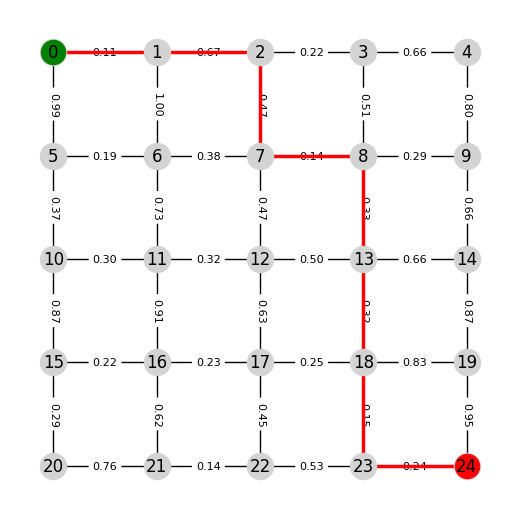

In [7]:
# Solve shortest path problem
path, obj = grid.solve()
print(ShortestPathGrid.one_hot_to_arcs(grid, path))

# Visualize the grid with the shortest path highlighted
grid.visualize(color_edges=path)

# Datasets
We use PyEPO to generate data for the shortest path problem and use its ``optDataset`` class for data storage and loading.

In [8]:
import pyepo

# Set parameters for data generation
num_train_data = 1000 # number of training data
num_test_data = 1000 # number of test data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(
    num_train_data+num_test_data, 
    num_feat, 
    (m,n), 
    deg=deg, 
    noise_width=e, 
    seed=135
)

In [9]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(
    feats, 
    costs, 
    test_size=num_test_data, 
    random_state=42
)

In [10]:
# Create datasets for training and testing
dataset_train = pyepo.data.dataset.optDataset(grid, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(grid, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 13097.21it/s]

Optimizing for optDataset...



100%|██████████| 1000/1000 [00:00<00:00, 13952.46it/s]


In [16]:
# Wrap dataset into PyTorch DataLoader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)